In [1]:
# Data Processing Libraries
import pandas as pd
import os
import csv
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

# Model Libraries 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import regularizers

2023-12-16 16:01:54.516731: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load Model Data 
Checkpoint: Load cached data here

In [2]:
# Test Loading Data
model_data_df = pickle.load(open('../data/model_data.pkl', 'rb'))
model_data_df

,race,sample_data,label
0,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Metaplastic carcinoma, NOS"
1,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Metaplastic carcinoma, NOS"
2,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
3,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
4,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
...,...,...,...
1495,not reported,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1496,not reported,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1497,black or african american,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1498,black or african american,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"


### Preprocess Data

In [3]:
# ONE HOT ENCODE DATA
encoded_labels = pd.get_dummies(model_data_df.label)
encoded_df = model_data_df.join(encoded_labels)


In [4]:
# Filter Data Frames by Race 
white_df = encoded_df[encoded_df["race"] == "white"]
black_df = encoded_df[encoded_df["race"] == "black or african american"]
asian_df = encoded_df[encoded_df["race"] == "asian"]
prognosis_names = encoded_df.label.unique()

# Train Test Split
def df_split(df): 
    split_index = int(0.7 * len(df)) 
    return df.iloc[:split_index], df.iloc[split_index:]

train_white_df, test_white_df = df_split(white_df) 
train_black_df, test_black_df = df_split(black_df) 
train_asian_df, test_asian_df = df_split(asian_df)

# Concatenate Final Sets 
train_df = train_white_df
# train_df = pd.concat([train_white_df, train_black_df, train_asian_df])

In [5]:
# PLOT MODEL PROGRESS
def plot_history(history, history_continued, tl_epoch): 
    # Get training history
    training_loss = history.history['loss'] + history_continued.history['loss']
    training_accuracy = history.history['accuracy'] + history_continued.history['accuracy']
    val_loss = history.history['val_loss'] + history_continued.history['val_loss']
    val_accuracy = history.history['val_accuracy'] + history_continued.history['val_accuracy']
    epochs = range(1, len(training_loss) + 1)

    # Plotting loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.axvline(x = tl_epoch, color = 'gray', label = 'transferred', linestyle='dotted')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.ylim(0, 1) 
    plt.plot(epochs, training_accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.axvline(x = tl_epoch, color = 'gray', label = 'transferred', linestyle='dotted')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

### DEFINE MODEL AND PREPARE DATA

In [6]:
# Prepare Model Data --> [takes 1 min. 15 sec.]
prognosis_names = encoded_df.label.unique()
def get_x_y(df): 
    x = np.stack(df.sample_data.values)
    y = df.filter(prognosis_names).values
    return x, y

def train_val_split(data):
    # returns: x_train, x_val, y_train, y_val
    x, y = data
    return train_test_split(x, y, test_size=0.15, random_state=42)


##### Main Code #########
x_train, x_val, y_train, y_val = train_val_split(get_x_y(train_df)) # training data

x_train_black, y_train_black = get_x_y(train_black_df)
x_train_asian, y_train_asian = get_x_y(train_asian_df)

x_test_white, y_test_white = get_x_y(test_white_df)
x_test_black, y_test_black = get_x_y(test_black_df)
x_test_asian, y_test_asian = get_x_y(test_asian_df)

In [7]:
# TRAIN NEURAL NETWORK
num_classes = model_data_df.label.nunique()

# Basic DNN Model 
reg_rate = 0.1
model = Sequential([
    Flatten(input_shape=(60623, 26)),  # Flattening the input
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(reg_rate)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(reg_rate)),
    Dense(num_classes, activation='softmax')  # Output layer with softmax for multi-class
])

def freeze_model(model): 
    model.trainable = False 
    model.layers[-1].trainable = True
    return model 


### Model Results for Freezing Last Layer

In [8]:
### RESULTS FOR BLACK / AA Patients 

# Reset and Compile the model
model.trainable = True
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Initial Model 
print("---------------------- TRAIN ON WHITE DATA ----------------------")
history = model.fit(x_train, y_train, epochs=8, batch_size=32, validation_data=(x_val, y_val))

# Freeze model 
model = freeze_model(model)

# Transfer Learning 
print("---------------------- TRANSFER TO BLACK + AA DATA ----------------------")
history_continued = model.fit(x_train_black, y_train_black, epochs=15, initial_epoch=history.epoch[-1], batch_size=32, validation_split=0.2)

---------------------- TRAIN ON WHITE DATA ----------------------
Epoch 1/8
19/19 [==============================] - 27s 1s/step - loss: 157.8075 - accuracy: 0.3904 - val_loss: 84.1385 - val_accuracy: 0.6822
Epoch 2/8
19/19 [==============================] - 23s 1s/step - loss: 79.7128 - accuracy: 0.5349 - val_loss: 41.1538 - val_accuracy: 0.6822
Epoch 3/8
19/19 [==============================] - 24s 1s/step - loss: 34.7895 - accuracy: 0.5199 - val_loss: 22.0704 - val_accuracy: 0.6822
Epoch 4/8
19/19 [==============================] - 28s 1s/step - loss: 23.2047 - accuracy: 0.5249 - val_loss: 13.6687 - val_accuracy: 0.6822
Epoch 5/8
19/19 [==============================] - 25s 1s/step - loss: 13.7521 - accuracy: 0.5615 - val_loss: 10.8483 - val_accuracy: 0.6916
Epoch 6/8
19/19 [==============================] - 23s 1s/step - loss: 10.8238 - accuracy: 0.6030 - val_loss: 9.0345 - val_accuracy: 0.7290
Epoch 7/8
19/19 [==============================] - 22s 1s/step - loss: 9.0170 - accuracy

In [9]:
# Check Test Performance - Black & AA Patients
evaluation = model.evaluate(x_test_black, y_test_black)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print("Performance on Black Patients")
print("----------------------------------")
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


3/3 [==============================] - 0s 67ms/step - loss: 5.0825 - accuracy: 0.8205
Performance on Black Patients
----------------------------------
Loss on test data: 5.082450866699219
Accuracy on test data: 0.8205128312110901


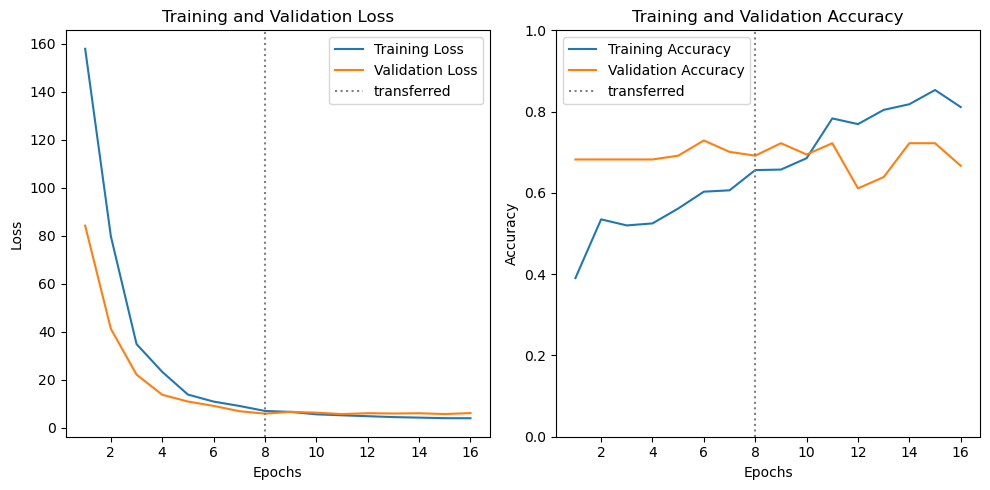

In [10]:
# PLOT MODEL PROGRESS
plot_history(history, history_continued, 8)

In [11]:
### RESULTS FOR Asian Patients 

# Reset and Compile the model
model.trainable = True
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Initial Model 
print("---------------------- TRAIN ON WHITE DATA ----------------------")
history = model.fit(x_train, y_train, epochs=8, batch_size=32, validation_data=(x_val, y_val))

# Freeze model 
model = freeze_model(model)

# Transfer Learning 
print("---------------------- TRANSFER TO ASIAN DATA ----------------------")
history_continued = model.fit(x_train_asian, y_train_asian, epochs=15, initial_epoch=history.epoch[-1], batch_size=32, validation_split=0.2)

---------------------- TRAIN ON WHITE DATA ----------------------
Epoch 1/8
19/19 [==============================] - 29s 1s/step - loss: 65.6036 - accuracy: 0.4551 - val_loss: 46.5728 - val_accuracy: 0.6822
Epoch 2/8
19/19 [==============================] - 26s 1s/step - loss: 30.1834 - accuracy: 0.5482 - val_loss: 15.2844 - val_accuracy: 0.6822
Epoch 3/8
19/19 [==============================] - 24s 1s/step - loss: 13.9759 - accuracy: 0.5797 - val_loss: 13.2303 - val_accuracy: 0.6822
Epoch 4/8
19/19 [==============================] - 24s 1s/step - loss: 13.2742 - accuracy: 0.5598 - val_loss: 11.1923 - val_accuracy: 0.7009
Epoch 5/8
19/19 [==============================] - 23s 1s/step - loss: 9.5554 - accuracy: 0.5664 - val_loss: 8.6983 - val_accuracy: 0.6822
Epoch 6/8
19/19 [==============================] - 23s 1s/step - loss: 7.8743 - accuracy: 0.6262 - val_loss: 10.6118 - val_accuracy: 0.3925
Epoch 7/8
19/19 [==============================] - 22s 1s/step - loss: 8.9058 - accuracy: 0

In [12]:
# Check Test Performance - Asian Patients
evaluation = model.evaluate(x_test_asian, y_test_asian)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print("Performance on Asian Patients")
print("----------------------------------")
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


1/1 [==============================] - 0s 222ms/step - loss: 3.2598 - accuracy: 0.8571
Performance on Asian Patients
----------------------------------
Loss on test data: 3.2597575187683105
Accuracy on test data: 0.8571428656578064


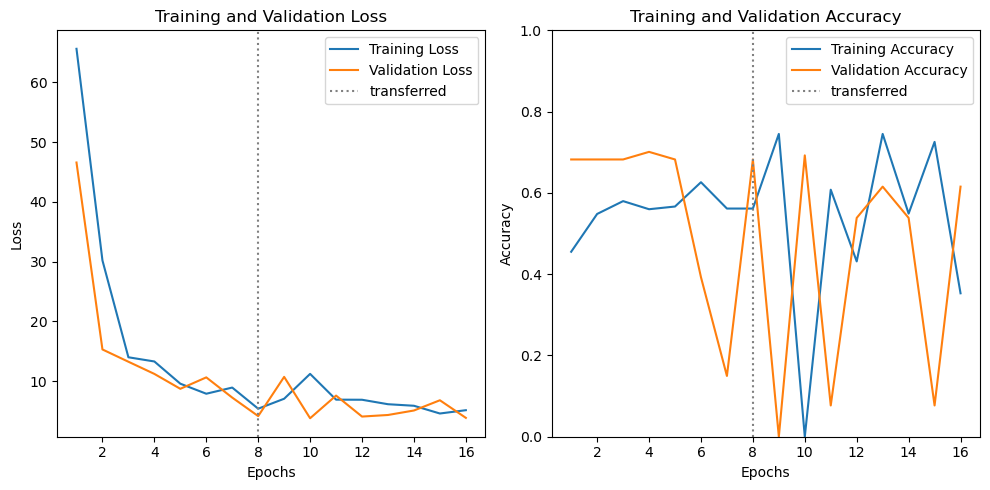

In [13]:
# PLOT MODEL PROGRESS
plot_history(history, history_continued, 8)

### Model Results for just Fine Tuning

In [14]:
### RESULTS FOR BLACK / AA Patients 

# Reset and Compile the model
model.trainable = True
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Initial Model 
print("---------------------- TRAIN ON WHITE DATA ----------------------")
history = model.fit(x_train, y_train, epochs=8, batch_size=32, validation_data=(x_val, y_val))

# Transfer Learning 
print("---------------------- TRANSFER TO BLACK + AA DATA ----------------------")
history_continued = model.fit(x_train_black, y_train_black, epochs=15, initial_epoch=history.epoch[-1], batch_size=32, validation_split=0.2)

---------------------- TRAIN ON WHITE DATA ----------------------
Epoch 1/8
19/19 [==============================] - 28s 1s/step - loss: 35.9487 - accuracy: 0.4734 - val_loss: 28.9035 - val_accuracy: 0.6355
Epoch 2/8
19/19 [==============================] - 24s 1s/step - loss: 21.6553 - accuracy: 0.4734 - val_loss: 13.1734 - val_accuracy: 0.6729
Epoch 3/8
19/19 [==============================] - 26s 1s/step - loss: 12.6061 - accuracy: 0.5365 - val_loss: 10.7965 - val_accuracy: 0.6822
Epoch 4/8
19/19 [==============================] - 25s 1s/step - loss: 12.3504 - accuracy: 0.5199 - val_loss: 7.6109 - val_accuracy: 0.6542
Epoch 5/8
19/19 [==============================] - 24s 1s/step - loss: 7.2937 - accuracy: 0.6163 - val_loss: 5.1388 - val_accuracy: 0.5701
Epoch 6/8
19/19 [==============================] - 23s 1s/step - loss: 4.9217 - accuracy: 0.5698 - val_loss: 4.2971 - val_accuracy: 0.4766
Epoch 7/8
19/19 [==============================] - 23s 1s/step - loss: 4.0229 - accuracy: 0.6

In [15]:
# Check Test Performance - Black & AA Patients
evaluation = model.evaluate(x_test_black, y_test_black)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print("Performance on Black Patients")
print("----------------------------------")
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


3/3 [==============================] - 0s 66ms/step - loss: 2.3110 - accuracy: 0.8205
Performance on Black Patients
----------------------------------
Loss on test data: 2.3110005855560303
Accuracy on test data: 0.8205128312110901


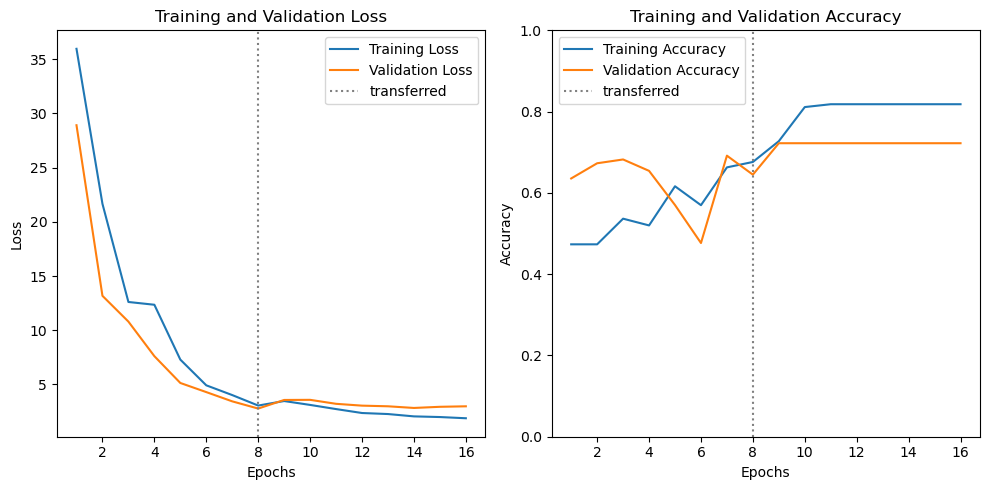

In [16]:
# PLOT MODEL PROGRESS
plot_history(history, history_continued, 8)

In [17]:
### RESULTS FOR Asian Patients 

# Reset and Compile the model
model.trainable = True
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Initial Model 
print("---------------------- TRAIN ON WHITE DATA ----------------------")
history = model.fit(x_train, y_train, epochs=8, batch_size=32, validation_data=(x_val, y_val))

# Transfer Learning 
print("---------------------- TRANSFER TO ASIAN DATA ----------------------")
history_continued = model.fit(x_train_asian, y_train_asian, epochs=15, initial_epoch=history.epoch[-1], batch_size=32, validation_split=0.2)

---------------------- TRAIN ON WHITE DATA ----------------------
Epoch 1/8
19/19 [==============================] - 29s 1s/step - loss: 25.9281 - accuracy: 0.4568 - val_loss: 21.4407 - val_accuracy: 0.2150
Epoch 2/8
19/19 [==============================] - 24s 1s/step - loss: 16.3622 - accuracy: 0.5548 - val_loss: 10.7429 - val_accuracy: 0.6822
Epoch 3/8
19/19 [==============================] - 24s 1s/step - loss: 8.1489 - accuracy: 0.5997 - val_loss: 5.1620 - val_accuracy: 0.6729
Epoch 4/8
19/19 [==============================] - 23s 1s/step - loss: 4.1880 - accuracy: 0.6495 - val_loss: 3.2074 - val_accuracy: 0.6822
Epoch 5/8
19/19 [==============================] - 23s 1s/step - loss: 2.8734 - accuracy: 0.6346 - val_loss: 2.4303 - val_accuracy: 0.6822
Epoch 6/8
19/19 [==============================] - 26s 1s/step - loss: 2.2118 - accuracy: 0.6628 - val_loss: 2.1780 - val_accuracy: 0.6822
Epoch 7/8
19/19 [==============================] - 26s 1s/step - loss: 2.1738 - accuracy: 0.6478

In [18]:
# Check Test Performance - Asian Patients
evaluation = model.evaluate(x_test_asian, y_test_asian)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print("Performance on Asian Patients")
print("----------------------------------")
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


1/1 [==============================] - 0s 235ms/step - loss: 2.1030 - accuracy: 0.8214
Performance on Asian Patients
----------------------------------
Loss on test data: 2.1029839515686035
Accuracy on test data: 0.8214285969734192


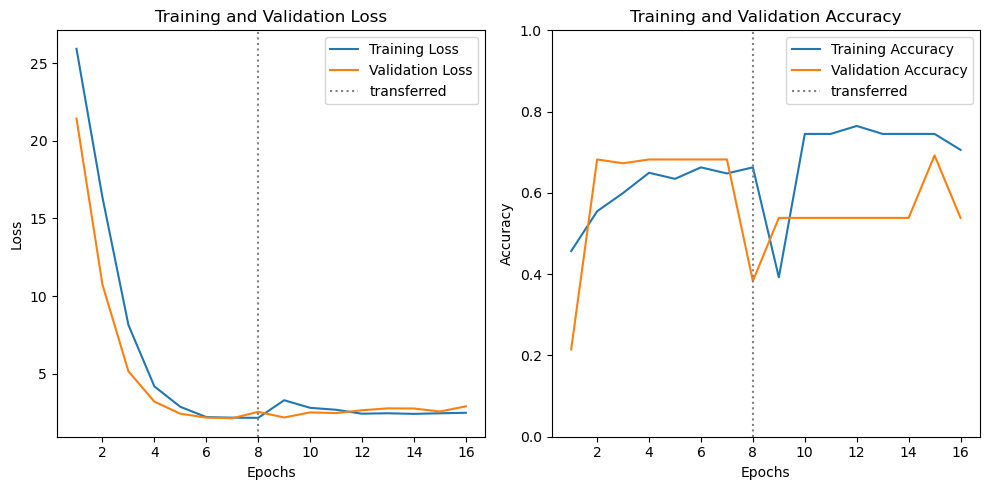

In [19]:
# PLOT MODEL PROGRESS
plot_history(history, history_continued, 8)